# 1. Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *
from project import *

In [3]:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

# 2. Zones
- The **UMN AAA data** uses the **2010** definitions of the census zones.
- **POI accessibility** uses travel times between zone centroids. The travel times obtained from Google Distance Matrix are for the **2010** zones.
- The **EJ Screen data** is available from 2015 to 2023. For the analysis, the **2020** data is used.

## 2.1. Download
<!-- Note that the TIGER/LINE boundaries and ACS data of the subdivisions of Indiana at different scales were already downloaded in [../../spr_4608/code/1_Geometry_ACS.ipynb](../../spr_4608/code/1_Geometry_ACS.ipynb), but they were for the year 2020 (I think). The files were then directly copied from `$MK/spr_4608/data/geometry` to `$MK/spr_4711/data/acs`. -->

<!-- However, since the UMN access data used the 2010 definitions, they are downloaded explicitly from the Census website. -->

In [4]:
def get_tiger_zones(scale, year, state='Indiana', name_col='name',
                    save=True, overwrite=False):
    old_api = year <= 2015
    outfile = Path(f'../data/zones/{scale.lower()}_{year}.parquet')
    zipfile = Path(f'../data/tiger_boundary_{scale}.zip')
    assert scale in ['TABBLOCK', 'BG', 'TAZ', 'TRACT', 'COUNTY', 'CBSA']
    if outfile.exists() and not overwrite:
        return
    print('Downloading zones at scale:', scale)
    fips = mk.geo.US_STATES_FIPS[state.upper()]
    if old_api:
        year_label = str(year % 2000)
        url = (f'https://www2.census.gov/geo/pvs/tiger{year}st/{fips}_{state}/'
               f'{fips}/tl_{year}_{fips}_{scale.lower()}{year_label}.zip')
    else:
        root = f'https://www2.census.gov/geo/tiger/TIGER{year}/{scale}'
        base = f'tl_{year}_{fips}_{scale.lower()}.zip'
        if scale == 'COUNTY':
            base = f'tl_{year}_us_county.zip'
        url = f'{root}/{base}'
    urllib.request.urlretrieve(url, zipfile)
    df = gpd.read_file(zipfile).to_crs(CRS_DEG)
    df = df.rename(columns=str.lower)
    if old_api:
        df = df.rename(columns=lambda x: x.replace(year_label, ''))
    if scale == 'COUNTY':
        df = df.query(f'statefp == "{fips}"').reset_index(drop=True)
    df = df[['geoid', name_col, 'aland', 'awater', 'geometry']]
    df = df.rename(columns={name_col: 'name'})
    if save:
        df.to_parquet(U.mkfile(outfile))
    zipfile.unlink()
    return df

In [5]:
years = [2010, 2020]
scales_names = [('COUNTY', 'name'), ('TRACT', 'namelsad'), ('BG', 'namelsad')]
for year, (scale, name_col) in it.product(years, scales_names):
    get_tiger_zones(scale, year, name_col=name_col, overwrite=0)

## 2.2. Combine table

In [8]:
def get_zones(scales=SCALES, year=2010, overwrite=False):
    outfile = Path(f'../data/zones/zones{year}.parquet')
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    df = pd.concat([
        gpd.read_parquet(f'../data/zones/{scale.lower()}{year}.parquet')
        .assign(scale=scale) for scale in scales
    ]).reset_index(drop=True)
    df.to_parquet(U.mkfile(outfile))
    return df

zones = get_zones(overwrite=0).set_crs(CRS_DEG).disp()

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: EPSG:4326


,geoid,name,aland,awater,geometry,scale
,<object>,<object>,<int64>,<int64>,<geometry>,<object>
0,18083,Knox,1336514262,20755159,"POLYGON ((-87.506221 38.733533, -87.506172 38....",COUNTY


# 3. [Relationship files](https://www.census.gov/geographies/reference-files/time-series/geo/relationship-files.2020.html)
These files show the mapping between the old (2010) and the new (2020) zones for [block groups](https://www2.census.gov/geo/docs/maps-data/data/rel2020/blkgrp/tab20_blkgrp20_blkgrp10_natl.txt), [tracts](https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_natl.txt), [counties](https://www2.census.gov/geo/docs/maps-data/data/rel2020/cousub/tab20_cousub20_cousub10_natl.txt).

In [7]:
def get_census_relationship(scale, keyword, state='Indiana', year1=2010,
                            year2=2020, save=True, overwrite=False):
    scale = scale.lower()
    label = f'{scale}-{year1}-{year2}'
    infile = f'../data/zones/xtab-{label}.txt'
    outfile = Path(f'../data/zones/relation-{label}.parquet')
    if outfile.exists() and not overwrite:
        return pd.read_parquet(outfile)
    y1, y2 = year1 % 2000, year2 % 2000
    df = pd.read_csv(infile, sep='|').rename(columns=str.lower)
    df = df.rename(columns=lambda x: x.replace('_' + keyword.lower(), ''))
    df = df.astype({f'geoid_{y1}': str, f'geoid_{y2}': str})
    max_len = df[f'geoid_{y1}'].str.len().max()
    for y in [y1, y2]:
        df[f'geoid_{y}'] = df[f'geoid_{y}'].str.zfill(max_len)
        df[f'state_{y}'] = df[f'geoid_{y}'].str.slice(0, 2)
    fips = f'{mk.geo.US_STATES_FIPS[state.upper()]:02}'
    df = df[(df[f'state_{y1}'] == fips) & (df[f'state_{y2}'] == fips)]
    df = df[[f'geoid_{y1}', f'geoid_{y2}',
             f'arealand_{y1}', f'arealand_{y2}', 'arealand_part',
             f'areawater_{y1}', f'areawater_{y2}', 'areawater_part']]
    df = df.dropna().reset_index(drop=True)
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

x = get_census_relationship('county', 'cousub', overwrite=0)
x = get_census_relationship('tract', 'tract', overwrite=0)
x = get_census_relationship('bg', 'blkgrp', overwrite=0)

In [8]:
bg1020 = pd.read_parquet('../data/zones/relation-bg-2010-2020.parquet').disp()

7,046 rows x 8 cols; Memory: 1.2 MiB


,geoid_10,geoid_20,arealand_10,arealand_20,arealand_part,areawater_10,areawater_20,areawater_part
,<object>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,180010301001,180010301001,59364016,59364016,59364016,161597,161597,161597


# 4. Visualize

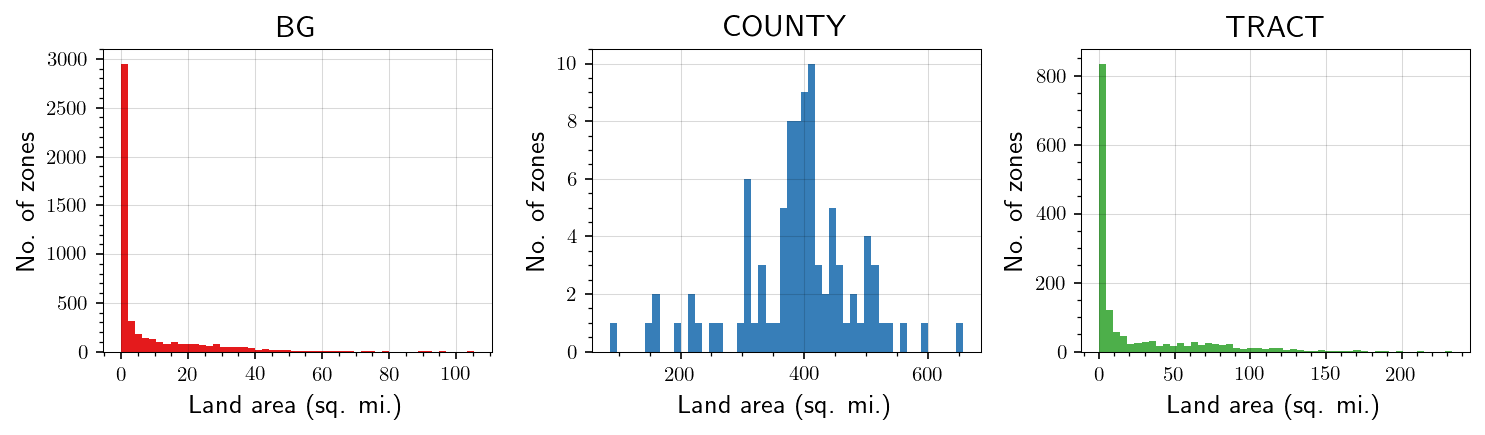

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=150)
for i, (scale, df) in enumerate(zones.groupby('scale')):
    ax = U.plot(axes[i], title=scale, xlab='Land area (sq. mi.)', ylab='No. of zones')
    (df.aland * U.SQM2SQMI).hist(ax=ax, bins=50, color=sns.color_palette('Set1', 3)[i])
plt.tight_layout()